Занятие 6. Линейная регрессия
===========

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#  matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
import os

os.chdir("C:/Users/USER/Documents/Python/_AD_Python_part_1_Lectures/AD_Python_1_05_regression_forecast/01_Series g")


### Прогнозирование временных рядов.

Прогноз объема международных авиаперевозок <br>
Версия 3

In [4]:
df = pd.read_csv('series_g.csv', sep=';')
df.head()

,date,series_g
0,JAN 1949,112
1,FEB 1949,118
2,MAR 1949,132
3,APR 1949,129
4,MAY 1949,121


Построим графики объёма авиаперевозок. <br> 
Надо разгадать тип тренда (линейный или нет) и характер сезонности (аддитивный или мультипликативный). <br>  
На первом графике для исходного ряда видны линейный тренд и мультипликативная сезонность. <br>
На втором графике ряд логарифмов исходного ряда. На нем сезонные поправки стали аддитивными, это подтверждает гипотезу о мультипликативном характере сезонности.

Text(0, 0.5, 'log10 от тысяч человек')

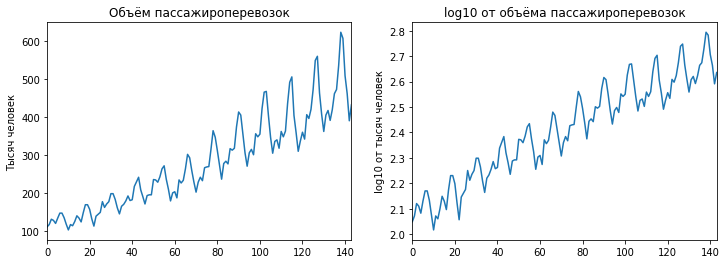

In [5]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['series_g'].plot(ax=ax1)
ax1.set_title(u'Объём пассажироперевозок')
ax1.set_ylabel(u'Тысяч человек')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['series_g'])).plot(ax=ax2)
ax2.set_title(u'log10 от объёма пассажироперевозок')
ax2.set_ylabel(u'log10 от тысяч человек')


Вывод: будем прогнозировать логарифм объёма перевозок с помощью модели линейной регрессии. 
$$\log y_i = \alpha + \beta \cdot x_i + c(x_i) + \varepsilon_i,$$
где $y_i$ -- объём перевозок, $x_i$ -- порядковый номер месяца, $c(x_i)$ -- сезонная составляющая, $\varepsilon_i$ -- случайные отклонения.

Прологарифмируем временной ряд. <br> Создадим предиктор ```month_num``` -- номер наблюдения, то есть номер месяца, считая от первого наблюдения.  Тем самым мы зададим линейный тренд. 

In [6]:
df['month_num'] = range(1, len(df) + 1)
df['log_y'] = np.log10(df['series_g'])

In [7]:
#  Все хорошо?
df.head()

,date,series_g,month_num,log_y
0,JAN 1949,112,1,2.049218
1,FEB 1949,118,2,2.071882
2,MAR 1949,132,3,2.120574
3,APR 1949,129,4,2.110590
4,MAY 1949,121,5,2.082785


In [8]:
#  Эти переменные в модели не нужны
df_2 = df.drop(columns=["date", "series_g"])

In [9]:
#  Все хорошо?
df_2.head()

,month_num,log_y
0,1,2.049218
1,2,2.071882
2,3,2.120574
3,4,2.110590
4,5,2.082785


Создадим новые переменные - индикаторы месяцев

In [10]:
df_2["m01"] = [1,0,0,0,0,0,0,0,0,0,0,0]*12
df_2["m02"] = [0,1,0,0,0,0,0,0,0,0,0,0]*12
df_2["m03"] = [0,0,1,0,0,0,0,0,0,0,0,0]*12
df_2["m04"] = [0,0,0,1,0,0,0,0,0,0,0,0]*12
df_2["m05"] = [0,0,0,0,1,0,0,0,0,0,0,0]*12
df_2["m06"] = [0,0,0,0,0,1,0,0,0,0,0,0]*12
df_2["m07"] = [0,0,0,0,0,0,1,0,0,0,0,0]*12
df_2["m08"] = [0,0,0,0,0,0,0,1,0,0,0,0]*12
df_2["m09"] = [0,0,0,0,0,0,0,0,1,0,0,0]*12
df_2["m10"] = [0,0,0,0,0,0,0,0,0,1,0,0]*12
df_2["m11"] = [0,0,0,0,0,0,0,0,0,0,1,0]*12
df_2["m12"] = [0,0,0,0,0,0,0,0,0,0,0,1]*12


In [11]:
#  Все хорошо?
df_2.head(14)

,month_num,log_y,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,1,2.049218,1,0,0,0,0,0,0,0,0,0,0,0
1,2,2.071882,0,1,0,0,0,0,0,0,0,0,0,0
2,3,2.120574,0,0,1,0,0,0,0,0,0,0,0,0
3,4,2.110590,0,0,0,1,0,0,0,0,0,0,0,0
4,5,2.082785,0,0,0,0,1,0,0,0,0,0,0,0
5,6,2.130334,0,0,0,0,0,1,0,0,0,0,0,0
6,7,2.170262,0,0,0,0,0,0,1,0,0,0,0,0
7,8,2.170262,0,0,0,0,0,0,0,1,0,0,0,0
8,9,2.133539,0,0,0,0,0,0,0,0,1,0,0,0
9,10,2.075547,0,0,0,0,0,0,0,0,0,1,0,0


In [12]:
#  Создаем таблицу (столбец) откликов.
y = df_2['log_y']

In [13]:
#  Создаем матрицу предикторов.
#  Убираем из нее отклик и столбец индикаторов базового месяца
X = df_2.drop(columns=["log_y", "m03"])

In [14]:
#  Подгонка модели
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Посмотрим на коэффициенты модели

In [15]:
coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,2.099793
1,month_num,0.004373
2,m01,-0.046979
3,m02,-0.056557
4,m04,-0.013580
5,m05,-0.014610
6,m06,0.038437
7,m07,0.083579
8,m08,0.079542
9,m09,0.016728


In [16]:
from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(list(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist())),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef

К коэффициентам модели добавим проверку гипотез о равенстве этих коэффициентов нулю.

In [17]:
regression_coef(model, X, y)

,predictor,coef,pvalue
0,intercept,2.099793,0.000000e+00
1,month_num,0.004373,0.000000e+00
2,m01,-0.046979,1.487224e-05
3,m02,-0.056557,2.717139e-07
4,m04,-0.013580,1.969117e-01
5,m05,-0.014610,1.652501e-01
6,m06,0.038437,3.426562e-04
7,m07,0.083579,4.376499e-13
8,m08,0.079542,3.735678e-12
9,m09,0.016728,1.126285e-01


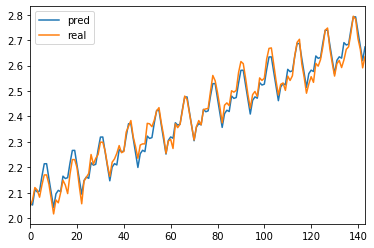

In [18]:
#  Сравним подгонку и ряд логарифмов

pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

In [19]:
#  Все хорошо?
pred.head(14)

,pred,real
0,2.057187,2.049218
1,2.051982,2.071882
2,2.112912,2.120574
3,2.103705,2.110590
4,2.107047,2.082785
5,2.164467,2.130334
6,2.213982,2.170262
7,2.214318,2.170262
8,2.155877,2.133539
9,2.100248,2.075547


Только что построили подгонку (fit), используя модель для временного ряда. <br>
Переходим к прогнозированию.

In [20]:
#  Готовим матрицу значений предикторов df_3 
#  для вычисления прогнозов на 12 месяцев вперед
#  Сначала добавляем в нее время (номер месяца)
df_3 = pd.DataFrame()

df_3['month_num'] = range(145, 157)


In [21]:
#  Все хорошо?
df_3.head()

,month_num
0,145
1,146
2,147
3,148
4,149


In [22]:
#  Добавляем индикаторы месяцев. Снова исключаем базовый месяц 
df_3["m01"] = [1,0,0,0,0,0,0,0,0,0,0,0]
df_3["m02"] = [0,1,0,0,0,0,0,0,0,0,0,0]
# df_3["m03"] = [0,0,1,0,0,0,0,0,0,0,0,0]
df_3["m04"] = [0,0,0,1,0,0,0,0,0,0,0,0]
df_3["m05"] = [0,0,0,0,1,0,0,0,0,0,0,0]
df_3["m06"] = [0,0,0,0,0,1,0,0,0,0,0,0]
df_3["m07"] = [0,0,0,0,0,0,1,0,0,0,0,0]
df_3["m08"] = [0,0,0,0,0,0,0,1,0,0,0,0]
df_3["m09"] = [0,0,0,0,0,0,0,0,1,0,0,0]
df_3["m10"] = [0,0,0,0,0,0,0,0,0,1,0,0]
df_3["m11"] = [0,0,0,0,0,0,0,0,0,0,1,0]
df_3["m12"] = [0,0,0,0,0,0,0,0,0,0,0,1]


In [23]:
#  Все хорошо?
df_3.head()

,month_num,m01,m02,m04,m05,m06,m07,m08,m09,m10,m11,m12
0,145,1,0,0,0,0,0,0,0,0,0,0
1,146,0,1,0,0,0,0,0,0,0,0,0
2,147,0,0,0,0,0,0,0,0,0,0,0
3,148,0,0,1,0,0,0,0,0,0,0,0
4,149,0,0,0,1,0,0,0,0,0,0,0


In [24]:
#  Предикторы готовы, можно вычислить прогноз для логарфмов
model.predict(df_3)


array([2.68687445, 2.68166899, 2.74259874, 2.73339167, 2.73673407,
       2.79415432, 2.84366872, 2.84400485, 2.78556367, 2.72993514,
       2.67189215, 2.72571592])

In [25]:
#  По прогнозу для логарифмов вычисляем прогноз для исходного ряда
y1 = 10**model.predict(df_3)

In [26]:
#  Ответ. Прогноз для исходного ряда.
y1

array([486.26661075, 480.47300064, 552.83907946, 541.24222483,
       545.42378389, 622.52144837, 697.70000261, 698.24020769,
       610.32852858, 536.95159299, 469.77743581, 531.76030967])

Но не будем спешить отсылать прогноз заказчику. <br>
Построим графики, чтобы проверить разумность полученного ответа.
Далее готовим данные для  графика.

In [27]:
#  К матрице pred с подгонкой добавим столбец 'forecast' с прогнозом.
#  В матрице информация об исторических значениях с 1-го по 144-ое
#  Поэтому для этих месяцев значение прогноза отсутствует.
pred['forecast'] = np.nan


In [28]:
#  Все хорошо?
pred.head()

,pred,real,forecast
0,2.057187,2.049218,NaN
1,2.051982,2.071882,NaN
2,2.112912,2.120574,NaN
3,2.103705,2.110590,NaN
4,2.107047,2.082785,NaN


In [34]:
#  Продолжение предыдущей матрицы. 
#  Оно содержит спрогнозированные значения для месяцев с 145-ый по 156-ой.
#  Для этих месяцев есть спрогнозированные значения, 
#  но нет исторических и подгонки.

#  Порядок столбцов не важен. 
#  Имена столбцов должны быть как в матрице pred выше

pred_2 = pd.DataFrame(model.predict(df_3), columns=['forecast'])
pred_2['real'] = np.nan
pred_2['pred'] = np.nan


In [35]:
#  Все хорошо?
pred_2.head()

,forecast,real,pred
0,2.686874,NaN,NaN
1,2.681669,NaN,NaN
2,2.742599,NaN,NaN
3,2.733392,NaN,NaN
4,2.736734,NaN,NaN


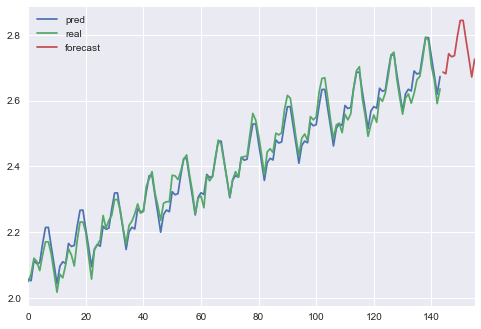

In [36]:
#  объединяем матрицы, задаем новые индексы
pred_3 = pd.concat(
    [pred, pred_2],
    sort=False
).reset_index(drop=True)

pred_3.plot()

In [37]:
#  От ряда из логарифмов возвращаемся к исходному ряду
pred_4 = 10**pred_3

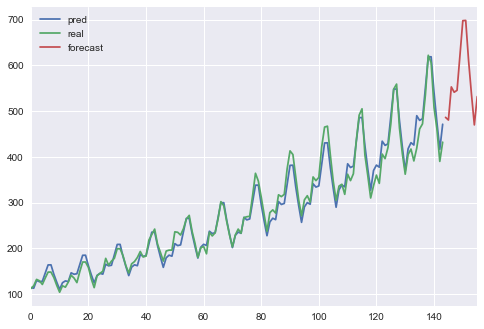

In [38]:
matplotlib.style.use('seaborn')
pred_4.plot()